In [ ]:
import math
import torch
import random
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
class CustomMountainCarWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomMountainCarWrapper, self).__init__(env)
        self.prev_state = None

    def step(self, action):
        next_state, _, terminated, truncated, info = self.env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        
        if self.prev_state is None:
            reward = 0.0
        else:
            prev_energy = math.sin(3 * self.prev_state[0]) * 0.0025 + 0.5 * (self.prev_state[1] ** 2)
            next_energy = math.sin(3 * next_state[0]) * 0.0025 + 0.5 * (next_state[1] ** 2)
            reward = 100 * (next_energy - prev_energy)
        if terminated:
            reward += 100
        self.prev_state = next_state.copy()
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        self.prev_state = np.array(state, dtype=np.float32)
        return state, info


In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=6):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, env, memory_capacity=20000, batch_size=64,
                 gamma=0.99, lr=0.0005, target_update=90,
                 epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.9995):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = DQN(input_dim=2, output_dim=self.env.action_space.n).to(self.device)
        self.target_net = DQN(input_dim=2, output_dim=self.env.action_space.n).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(memory_capacity)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)
        q_values = self.policy_net(states).gather(1, actions)
        
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        loss = nn.functional.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes=1000, max_steps=200, model_save_path="/Users/om_gaydhane/Downloads/a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth"):
        rewards_per_episode = []
        epsilon_per_episode = []
        best_reward = float("-inf")

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0

            for t in range(max_steps):
                action = self.select_action(state)
                next_state, _, done, _, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)
                reward = 100 * ((math.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] ** 2) -
                                (math.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] ** 2))
                next_state = np.array(next_state, dtype=np.float32)
                self.memory.push((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward
                self.optimize_model()
                if done:
                    break

            if episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            epsilon_per_episode.append(self.epsilon)
            rewards_per_episode.append(total_reward)
            if total_reward > best_reward:
                best_reward = total_reward
                self.save_model(model_save_path)
                print(f"Best model: Episode {episode}, Reward: {total_reward}")
            if episode % 100 == 0:
                print(f"Episode {episode}, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
        return rewards_per_episode, epsilon_per_episode

    def save_model(self, filename="/Users/om_gaydhane/Downloads/a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="/Users/om_gaydhane/Downloads/a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [ ]:
env = gym.make("MountainCar-v0", render_mode="human")
env = CustomMountainCarWrapper(env)
agent = DQNAgent(env)
rewards, epsilons = agent.train(num_episodes=1000, model_save_path="/Users/om_gaydhane/Downloads/a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth")

Best model: Episode 0, Reward: -0.005529634654521942
Episode 0, Total reward: -0.005529634654521942, Epsilon: 1.000
Best model: Episode 1, Reward: 0.0021873274818062782
Best model: Episode 2, Reward: 0.005821976810693741
Best model: Episode 3, Reward: 0.012290912680327892
Best model: Episode 4, Reward: 0.05871228501200676
Best model: Episode 10, Reward: 0.0670987218618393
Best model: Episode 44, Reward: 0.15393026173114777
Best model: Episode 84, Reward: 0.2239142507314682
Episode 100, Total reward: 0.00664745457470417, Epsilon: 0.960
Episode 200, Total reward: 0.010974216274917126, Epsilon: 0.923
Episode 300, Total reward: 0.03351147845387459, Epsilon: 0.887
Episode 400, Total reward: 0.0167093463242054, Epsilon: 0.852
Best model: Episode 463, Reward: 0.22982269525527954
Best model: Episode 478, Reward: 0.2909504175186157
Episode 500, Total reward: 0.08628858625888824, Epsilon: 0.818
Best model: Episode 508, Reward: 0.3444322943687439
Episode 600, Total reward: 0.08526823669672012, Ep

> Epsilon Decay Graph

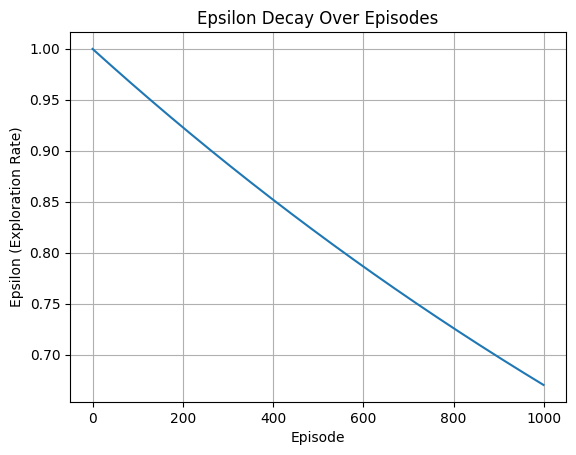

In [19]:
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Epsilon Decay Over Episodes")
plt.grid(True)
plt.show()

> Total Rewards per Episode

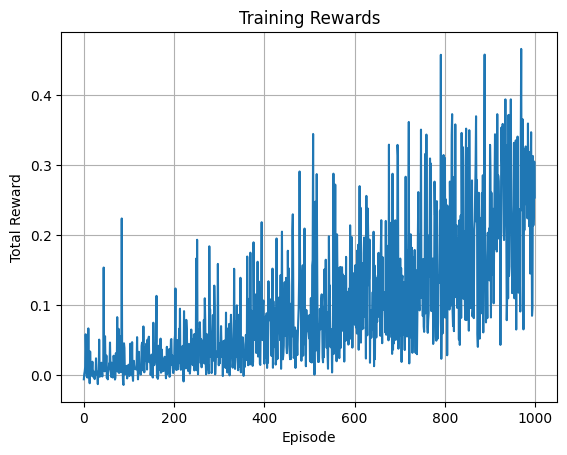

In [20]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards")
plt.grid(True)
plt.show()

> Running the agent for 10 episodes, where
the agent chooses only greedy actions from the learnt policy.

In [ ]:
env = gym.make("MountainCar-v0", render_mode="human")
agent.load_model("/Users/om_gaydhane/Downloads/a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth")

eval_rewards = []
for episode in range(10):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
            action = agent.policy_net(state_tensor).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(next_state, dtype=np.float32)
        total_reward += reward
        done = terminated or truncated

    eval_rewards.append(total_reward)
    print(f"Episode {episode+1}, Total Reward: {total_reward}")
env.close()

Episode 1, Total Reward: -99.0
Episode 2, Total Reward: -169.0
Episode 3, Total Reward: -95.0
Episode 4, Total Reward: -200.0
Episode 5, Total Reward: -165.0
Episode 6, Total Reward: -166.0
Episode 7, Total Reward: -187.0
Episode 8, Total Reward: -106.0
Episode 9, Total Reward: -171.0
Episode 10, Total Reward: -136.0


> Total Reward per Episode for Evaluation

/var/folders/c5/l_rlzbnd5b5bsdf_zp23bj5m0000gn/T/ipykernel_3666/2399744707.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


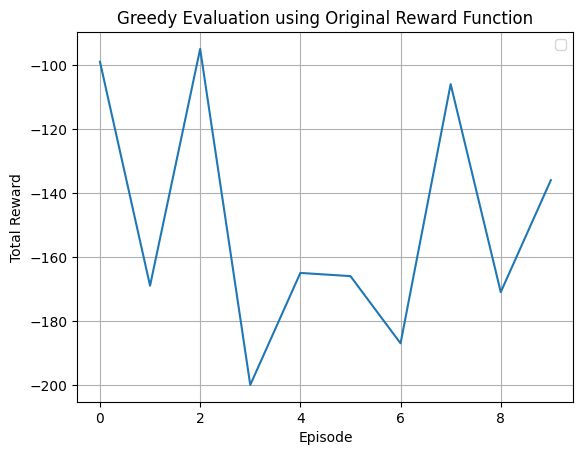

In [30]:
plt.plot(eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Evaluation using Original Reward Function")
plt.legend()
plt.grid(True)
plt.show()

> 1 episode where the agent chooses only
greedy actions from the learned policy

In [ ]:
env = gym.make("MountainCar-v0", render_mode="human")
agent.load_model("/Users/om_gaydhane/Downloads/a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth")
state, _ = env.reset()
state = np.array(state, dtype=np.float32)
total_reward = 0
done = False
step = 0

while not done:
    env.render()
            
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():
        action = agent.policy_net(state_tensor).argmax().item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = np.array(next_state, dtype=np.float32)
    print(f"Step {step}: State = {np.round(state, 4)}, Action = {action}, Reward = {reward:.2f}")
    total_reward += reward
    state = next_state
    done = terminated or truncated
    step += 1
env.close()
print(f"Greedy episode total reward: {total_reward}")

Step 0: State = [-0.4336  0.    ], Action = 0, Reward = -1.00
Step 1: State = [-0.4353 -0.0017], Action = 0, Reward = -1.00
Step 2: State = [-0.4386 -0.0033], Action = 0, Reward = -1.00
Step 3: State = [-0.4436 -0.005 ], Action = 0, Reward = -1.00
Step 4: State = [-0.4501 -0.0065], Action = 0, Reward = -1.00
Step 5: State = [-0.4582 -0.0081], Action = 0, Reward = -1.00
Step 6: State = [-0.4678 -0.0096], Action = 0, Reward = -1.00
Step 7: State = [-0.4788 -0.011 ], Action = 0, Reward = -1.00
Step 8: State = [-0.4911 -0.0123], Action = 0, Reward = -1.00
Step 9: State = [-0.5047 -0.0136], Action = 0, Reward = -1.00
Step 10: State = [-0.5194 -0.0147], Action = 0, Reward = -1.00
Step 11: State = [-0.5351 -0.0157], Action = 0, Reward = -1.00
Step 12: State = [-0.5518 -0.0167], Action = 0, Reward = -1.00
Step 13: State = [-0.5693 -0.0175], Action = 0, Reward = -1.00
Step 14: State = [-0.5874 -0.0181], Action = 0, Reward = -1.00
Step 15: State = [-0.606  -0.0186], Action = 0, Reward = -1.00
St